In [215]:
#%matplotlib widget
from time import time
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage
from itertools import islice

In [216]:
flatten = lambda l: [item for sublist in l for item in sublist]

def frames():
    vidcap = cv2.VideoCapture('../data/train.mp4')
    while True:
        success, image = vidcap.read()
        if success:
            image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            yield image
        else:
            return

def cframes():
    for im in frames():
        yield crop(im)

def adjacent(iterable):
    # yields i(n), i(n-1)
    # doubling on the last item so to keep length the same
    last_x = None
    for x in iterable:
        if last_x is not None:
            yield x, last_x
        last_x = x
    yield x, last_x

originy=None
def crop(im, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = im.shape[0]/2 - top
    return im[top:im.shape[0]-bottom,:]

def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) >= n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    print(f"Using {len(chunks):0d} chunks")
    return pd.concat(chunks, axis=0)    

In [217]:
def quick_view(fs, frames_per_step=1, start=1000, stop=1010):
    for i, im in enumerate(fs):
        if not (start<i<stop):
            if i>stop:
                break
            continue
        if i % frames_per_step != 0:
            continue
        cv2.imshow('oned',im)
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()

#quick_view(cframes(), frames_per_step=1, start=60, stop=180)

In [218]:
# blur/focus based
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def tile(im, nrows=1, ncolumns=6):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for y in range(0,N*ncolumns,N):
        row = []
        for x in range(0,M*nrows,M):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    return rows

def via_variance_of_laplacian(image):
    tiles = tile(image, 8, 20)
    return [variance_of_laplacian(i) for i in flatten(tiles)]

In [321]:
# Optical Flow Based
def via_lk_optical_flow(im, last_im, debugging=False):
    # params for ShiTomasi corner detection
    feature_params = dict(
        maxCorners = 600,
        qualityLevel = 0.0005,
        minDistance = 4,
        blockSize = 11,
        useHarrisDetector = True,
        )

    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (15,15),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
        )
    
    p0 = cv2.goodFeaturesToTrack(last_im, mask = None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(last_im, im, p0, None, **lk_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(last_im)
    
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    
    # setup zenith
    shape=im.shape
    #ys,xs = np.indices(shape)
    x_offset = shape[1] // 2
    y_offset = int(originy)
    
    img = im.copy()

    df = pd.DataFrame()
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a1,b1 = old.ravel()
        a2,b2 = new.ravel()
        
        dx, dy = (a2-a1), (b2-b1)
        Vf_slope = dy/dx
        Vf_mag = (dx**2 + dy**2)**0.5
        if Vf_mag <3:
            #not moved enough
            continue
        
        x1, y1 = a1-x_offset, b1-y_offset
        x2, y2 = a2-x_offset, b2-y_offset
        
        intercept = y1 - Vf_slope * x1
        
        
        dot = x1*(dx) + y1*(dy)
        
        Vr_mag = ((x1**2) + (y1**2))**0.5
        Vm_mag = dot/Vr_mag
        
        df.loc[i,'|Vf|'] = Vf_mag
        df.loc[i,'|Vm|'] = Vm_mag
        df.loc[i,'intercept'] = intercept
        df.loc[i,'inter/|Vr|'] = intercept/Vr_mag
        
        right_direction = abs(x1*y1) < abs(x2*y2)
        df.loc[i,'right_dir'] = right_direction
        
        if (-75.0<intercept) and (intercept<25.0) and right_direction:
            color=255
            df.loc[i,'good'] = True
        else:
            color=130
            df.loc[i,'good'] = False
        
        if debugging:
            img = cv2.line(img, (x_offset,y_offset),(a1,b1), 0)
            img = cv2.arrowedLine(img, (a1,b1),(a2,b2), color, tipLength=.3)
            img = cv2.circle(img,(a1,b1),2,color, -1)

    if debugging:
        if len(df) == 0:
            print("no useful points")
        else:
            display(df.sort_values(by='|Vm|'))       
            bins = list(range(0,31,10))
            plt.rcParams['figure.figsize'] = [20, 5]
            df['|Vm|'].hist(bins=bins)
            df[df['good']==True]['|Vm|'].hist(bins=bins)
            plt.show()

        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(img)
        plt.show()

    if len(df) == 0:
        return [np.nan]
    else:
        return [df.loc[df['good'],'|Vm|'].mean(),]

In [322]:
# Process images
def extract_features(images):
    start = time()
    xs=[]
    for i, (im, last_im) in enumerate(adjacent(images)):
        blur_vec = []#via_variance_of_laplacian(im)
        lk_vec = via_lk_optical_flow(im, last_im)

        xs.append(lk_vec+blur_vec)

        if ((i+1) % 1000) == 0:
            print(f"{i+1} proccessed in {(time()-start)/60:2.1f} minutes")
    print(f"{i+1} proccessed in {(time()-start)/60:2.1f} minutes")
    return xs


In [323]:
xs_test = extract_features(islice(cframes(), 1200)) # first 100
#xs = extract_features(cframes())

1 proccessed in 0.0 minutes


<ipython-input-321-e0c44b6706ad>:45: RuntimeWarning: divide by zero encountered in float_scalars
  Vf_slope = dy/dx


1001 proccessed in 0.4 minutes
1200 proccessed in 0.5 minutes


<ipython-input-321-e0c44b6706ad>:45: RuntimeWarning: invalid value encountered in float_scalars
  Vf_slope = dy/dx


In [324]:
X = pd.DataFrame(xs_test)

<AxesSubplot:>

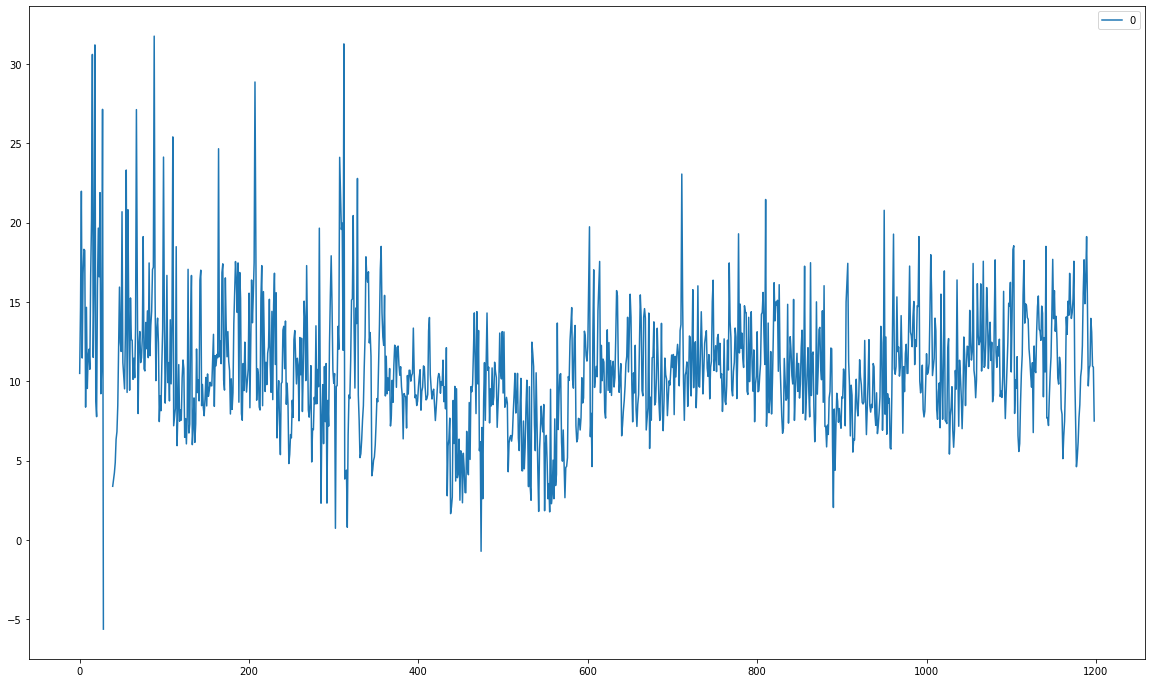

In [326]:
X.plot(y=0)


In [280]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)
X.fillna(method='pad', inplace=True)

Xy = X.copy(deep=True)
Xy['y'] = y

chunksize = 60
chunksize = 2040 # ten chunks
chunksize = 204*2 # 50
Xy = shuffle_time_in_chunks(Xy, chunksize)
Xy

Using 50 chunks


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,y
17136,266.272640,24.199607,45.863086,23.589834,6.648350,67.863975,4.424219,2.459365,13.947646,10.983584,...,3.948240,14.512009,29.286306,247.504678,35.821853,1.240615,35.643594,0.331240,1.624209,1.201911
17137,266.272640,21.904099,40.321875,21.866482,6.520779,65.831736,4.876523,2.887490,13.674209,11.706580,...,3.917068,15.888025,44.932810,147.634756,38.493350,1.074521,39.943533,0.373435,1.451267,1.189456
17138,266.272640,17.825625,41.152256,25.105544,11.342380,59.840615,5.085303,2.546250,11.602773,9.596250,...,4.371836,13.903711,48.748398,142.540469,43.166211,1.282969,45.257969,0.303115,1.585642,1.188118
17139,266.272640,24.389443,46.500625,26.298818,11.270615,73.362100,4.663125,2.876443,13.501523,7.194900,...,3.952969,6.903708,70.882166,186.644375,59.786326,1.750303,53.665134,0.340625,1.800303,1.171291
17140,266.272640,26.710349,37.336306,24.917029,7.038865,88.054197,4.397500,2.572361,9.920615,4.620193,...,3.878115,2.626541,48.294834,135.046970,91.445693,3.033279,55.219021,0.412500,1.628806,1.154505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,175.276567,200.876443,12.346384,7.098318,1.774961,2.627773,2.030771,0.859336,9.852908,54.458193,...,9.496875,123.968689,29.902869,73.385525,0.914041,2.593594,0.485916,0.460916,8.107615,23.112378
2036,197.595535,21.521462,8.012283,5.816482,1.557810,2.671719,1.801365,0.948416,9.709023,59.582224,...,8.196836,134.628711,38.043398,71.196619,133.137148,2.152969,0.362490,0.184375,7.475857,23.118574
2037,112.399067,35.678086,9.434861,5.298594,2.448240,2.674844,1.946523,1.043711,9.071719,13.766111,...,8.643398,95.999961,31.911709,73.672500,208.494431,2.282751,0.345310,0.200000,6.454053,23.094664
2038,80.539454,14.614001,9.459158,5.121912,15.357725,2.710586,1.847888,1.843740,9.007461,15.865000,...,9.992185,62.938711,26.251755,73.366250,37.920251,2.399844,0.429568,0.168750,7.650681,23.104091


In [249]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8976
Percent test    = 0.44


In [250]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

m_dum = DummyRegressor(strategy='mean')

pipe = Pipeline([
        ('scale', StandardScaler()),
        #'reduce_dims', PCA(n_components=4)),
        #('svr', SVR(C=20)),
        #('rf', RandomForestRegressor()),
        #'mlp', MLPRegressor(shuffle=False, alpha=0.1)),
        #('br', BayesianRidge()),
        ('stack', StackingRegressor([
            ('svr', SVR(C=20)),
            ('rf', RandomForestRegressor()),
            ('mlp', MLPRegressor(shuffle=False, alpha=0.1)),
            ]))
    ])

# # Training classifiers
# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# BaysianRidge
# MLP NN

from sklearn.model_selection import GridSearchCV
parameters = {
    #'svr__C':[.01, .1, .3, .9, 2, 4, 10, 20],
    #'svr__C':[10, 20, 30, 40, 70, 120],
    'mlp__alpha':[0.0001, 0.001, 0.01],
    #'svr__C':[.3],RandomForestRegressor
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=5, cv=5)

m_real = pipe


In [251]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Pipeline(steps=[('scale', StandardScaler()),
                ('stack',
                 StackingRegressor(estimators=[('svr', SVR(C=20)),
                                               ('rf', RandomForestRegressor()),
                                               ('mlp',
                                                MLPRegressor(alpha=0.1,
                                                             shuffle=False))]))])


In [252]:
# recreate full original df
Xy_test.loc[:,'is_test'] = True
Xy_train.loc[:,'is_test'] = False
Xy2 = pd.concat([Xy_test,Xy_train]).sort_index()

# get predictions
Xy2['dum'] = m_dum.predict(Xy2[X.columns])
Xy2['pred'] = m_real.predict(Xy2[X.columns])

# for convience
Xy2_test_ix = Xy2['is_test'] == True
Xy2_train_ix = Xy2['is_test'] == False

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [253]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.00035]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
kf_tuned = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [254]:
# never below 0
Xy2.loc[Xy2['pred']<0.0,'pred'] = 0.0

In [255]:
# apply kalman
Xy2.loc[Xy2_test_ix,'pred_kf'] = kf_tuned.smooth(Xy2.loc[Xy2_test_ix,'pred'].values)[0]

In [256]:
Xy2

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,y,is_test,dum,pred,pred_kf
0,88.392115,4.249756,3.350955,4.870615,2.115798,1.276150,1.668750,0.966892,2.086130,47.896250,...,108.282517,10.184678,1.601541,1.007615,1.461094,28.105569,False,12.089961,28.121282,NaN
1,154.361983,9.946084,2.697830,5.119336,5.680076,1.500681,1.704568,1.038357,1.994177,113.568337,...,101.712803,17.016775,0.803806,0.826365,1.808279,28.105569,False,12.089961,27.401964,NaN
2,135.095630,75.923728,2.688083,4.759365,65.992126,1.403125,1.746084,1.396475,2.780564,56.970681,...,100.460459,17.106240,1.411523,0.921865,1.500486,28.106527,False,12.089961,28.397625,NaN
3,109.403293,75.409939,2.624131,4.611814,64.081250,1.260525,1.690469,0.974648,2.819961,10.986794,...,95.397849,25.774961,1.161318,0.757615,1.412537,28.130404,False,12.089961,28.515529,NaN
4,106.083954,5.483884,3.783750,5.318396,61.890625,1.499648,1.770291,1.099844,3.395583,6.954490,...,98.139844,18.020447,1.296631,0.801443,1.581287,28.109243,False,12.089961,27.878593,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,162.003772,44.112087,34.293594,6.771475,4.979470,11.029392,3.098337,4.034412,21.717773,149.603037,...,3.624961,18.322178,8.312500,16.743398,3.154138,2.329180,False,12.089961,0.703560,NaN
20396,170.942023,60.329648,39.476599,8.116892,5.277908,8.909023,5.253086,3.335303,21.605068,160.726501,...,2.943740,13.360000,5.921091,14.876560,3.617568,2.289795,False,12.089961,0.738895,NaN
20397,173.938698,84.552517,47.651719,12.171658,6.269021,13.292654,7.213584,3.788975,23.769375,200.640798,...,2.752773,19.537412,7.405154,16.993259,3.149756,2.292917,False,12.089961,0.674875,NaN
20398,177.152308,88.645273,38.674521,12.007461,6.466775,13.769961,6.535935,3.710303,21.013650,194.947400,...,3.186875,16.264001,7.149648,18.065408,3.573142,2.260600,False,12.089961,0.518326,NaN


In [260]:
Xy2[0] *= .1

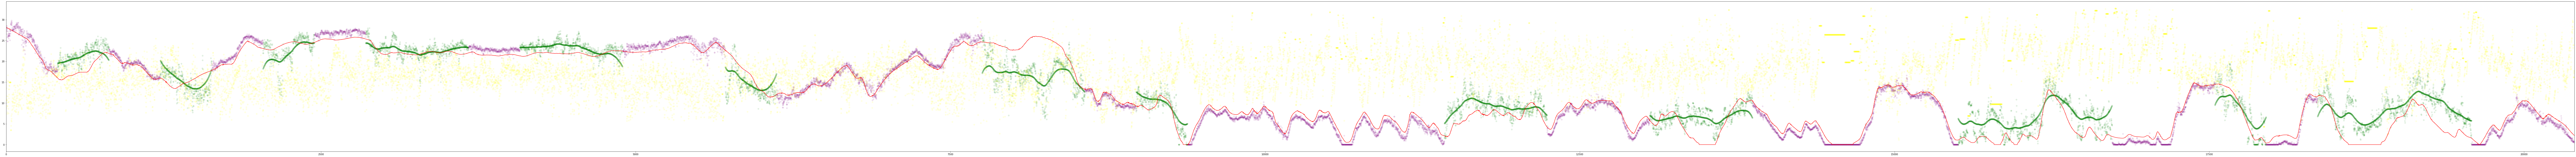

In [262]:
plt.rcParams['figure.figsize'] = [200, 12]
plt.gca().set_xlim((0,len(Xy2)))
def plot_Xy2(ix_mask, column, **kwargs):
    if ix_mask is None:
        df = Xy2.loc[:,column]
    else:
        df = Xy2.loc[ix_mask, column]
    plt.plot(df.index, df.values, **kwargs)
    
plot_Xy2(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)
plot_Xy2(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)
plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_Xy2(None, 0, marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot_Xy2(None, 'y', marker='', linewidth=1.4, color='red')

In [258]:
def print_summary_line(ix_mask, column='dum'):
    Xy = Xy2[ix_mask]
    err = mean_squared_error(Xy['y'], Xy[column])
    print(f"{err:0.1f}", end=' ')

print(f"dummy test train test_kf")
print_summary_line(Xy2_test_ix,'dum')
print_summary_line(Xy2_test_ix,'pred')
print_summary_line(Xy2_train_ix,'pred')
print_summary_line(Xy2_test_ix,'pred_kf')

dummy test train test_kf
74.5 16.9 1.4 13.6 